In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [2]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [3]:
import yfinance as yf 


In [4]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="D",periods=len(usd)))
usd=usd.dropna()
usd

,USD/TL
2006-01-02,1.3483
2006-01-03,1.3506
2006-01-04,1.3484
2006-01-05,1.3381
2006-01-06,1.3362
...,...
2024-06-26,32.9608
2024-06-27,32.9633
2024-06-28,32.9009
2024-07-01,32.8853


In [5]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-01-31,1984.02
2024-02-29,2073.88
2024-03-31,2139.47
2024-04-30,2207.50


In [6]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-02-29,1.467195
2024-03-31,2.396667
2024-04-30,1.982216
2024-05-31,1.859475


In [7]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-02-29,2.359600
2024-03-31,2.687835
2024-04-30,2.405048


In [8]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-12-31,8.8
2024-01-31,9.0
2024-02-29,8.7
2024-03-31,8.6


In [9]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-02-29,81.623999
2024-03-31,84.665499
2024-04-30,88.999999


In [10]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-02-29,3.130261
2024-03-31,4.108658
2024-04-30,1.832087


In [11]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-03-31,47.287619
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.106471


In [12]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar (3).xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-01-31,39.7935
2024-02-29,43.0968
2024-03-31,42.0568
2024-04-30,42.6763


In [13]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-02-29,51.460000
2024-03-31,57.272000
2024-04-30,67.567500
2024-05-31,64.538000


In [14]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-02-29,0.94
2024-03-31,0.64
2024-04-30,0.55
2024-05-31,0.47


In [15]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-01-31,6.717124
2024-02-29,4.070637
2024-03-31,3.926249
2024-04-30,4.894259


In [16]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-01-31,2.305439
2024-02-29,7.576163
2024-03-31,3.571725
2024-04-30,3.524351


In [17]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-01-31,4.136164
2024-02-29,3.737000
2024-03-31,3.294983
2024-04-30,3.602753


In [18]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2024-01-31,-0.013509
2024-02-29,-12.996120
2024-03-31,5.560892
2024-04-30,7.087821


In [19]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2024-01-31,0.410951
2024-02-29,-9.739818
2024-03-31,6.280869
2024-04-30,7.387077


In [20]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-02-29,3.80
2024-03-31,3.43
2024-04-30,3.25
2024-05-31,3.04


In [23]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data=data.pct_change()*100
data["M3"]=m3["M3"].shift(1)
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"].shift(1)
data["TÜFECt2"]=tufec["TÜFE C"].shift(2)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data

,USD/TL,Motorin,TÜFE,TÜFEt-1,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,0.218500,NaN,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.274548,0.218500,2.204708,0.256616,NaN,NaN,NaN,0.137253,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,1.336769,0.274548,2.711175,0.247960,0.256616,-1.101304,NaN,2.088936,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,1.875397,1.336769,1.323922,1.938881,0.247960,-0.368460,-1.101304,1.595826,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,3.239458,-2.413172,3.162671,4.529188,2.359600,3.737000,4.136164,7.576163,2.305439,3.926249,5.560892,6.280869,3.43
2024-04-30,2.452282,1.473008,3.179759,3.162671,2.687835,3.294983,3.737000,3.571725,7.576163,4.894259,7.087821,7.387077,3.25
2024-05-31,1.565526,-3.259186,3.368063,3.179759,2.405048,3.602753,3.294983,3.524351,3.571725,3.589407,-14.766322,-2.558099,3.04
2024-06-30,0.553511,0.000000,0.000000,3.368063,3.532013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.52


In [24]:

data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data=data.iloc[:-1]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)

data["İşsizlik"].iloc[-2:]=8.4


data=data.loc["2014-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["İhracat"].iloc[-2:]=[-14.64,25.04]
data["İthalat"].iloc[-2:]=[-2.65,5.07]
data["ÜFEt1"].iloc[-1]=1.96
data["ÜFEt2"].iloc[-1]=3.60
data["TÜFECt1"].iloc[-1]=3.76
data["Motorin"].iloc[-1]=-1.61
data["TÜFECt2"].iloc[-1]=3.5243
data=data.dropna()
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2014-01-31,3.732429,2.881984,3.413428,0.37,5.265777,0.460607,3.375162,2.886648,-7.844611,7.652883,9.0220,1.06,9.2,7.503636,0.618013,1.776282,1.106494,0.625859,0.333618,1.978080
2014-02-28,3.033477,1.685899,1.958423,0.31,0.000000,1.978080,1.804994,2.214819,-6.175956,-14.641565,10.6275,0.69,9.5,10.070500,1.106494,0.625859,3.319203,-0.111246,1.009554,0.428192
2014-03-31,2.465778,-2.278097,0.229599,0.16,0.000000,0.428192,0.451349,1.160171,4.991889,-6.505852,11.3125,0.65,9.5,10.200952,3.319203,-0.111246,1.383675,0.308798,0.989257,1.125608
2014-04-30,-1.344724,-6.214384,0.730196,0.23,0.000000,1.125608,0.796760,0.126575,12.575902,13.043316,11.0200,0.76,9.7,10.046190,1.383675,0.308798,0.736212,0.701489,2.649799,1.344970
2014-05-31,-1.859714,-0.561578,-0.093468,0.26,0.000000,1.344970,-0.362357,0.464970,-7.919312,0.662228,10.4940,0.63,9.7,9.891000,0.736212,0.701489,0.085477,1.197755,0.211698,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,2.418218,8.301104,1.119951,0.94,0.000000,6.703310,0.992308,2.597683,-12.996120,-9.739818,51.4600,3.80,8.7,45.239524,1.144328,1.960293,4.136164,2.305439,4.070637,4.529188
2024-03-31,3.239458,-2.413172,2.359600,0.64,0.000000,4.529188,1.467195,3.009414,5.560892,6.280869,57.2720,3.43,8.6,47.287619,4.136164,2.305439,3.737000,7.576163,3.926249,3.162671
2024-04-30,2.452282,1.473008,2.687835,0.55,0.000000,3.162671,2.396667,3.023668,7.087821,7.387077,67.5675,3.25,8.5,51.357222,3.737000,7.576163,3.294983,3.571725,4.894259,3.179759
2024-05-31,1.565526,-3.259186,2.405048,0.47,0.000000,3.179759,1.982216,2.979092,-14.640000,-2.650000,64.5380,3.04,8.4,50.544545,3.294983,3.571725,3.602753,3.524351,3.589407,3.368063


## Cari Ay Enflasyon Tahmini

In [27]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Zam,ParaArzi,Kredi,Anket,İhracat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.436647,0.120222,0.254853,0.388678,0.647802,-0.357034,-0.695105,-1.224068,-0.544829,0.010796,-0.384633,-0.534925,0.039845
1,0.227287,-0.041395,-0.293182,-0.180780,0.188025,-0.632840,-0.567125,-1.025656,-0.380604,-0.529398,0.360123,-0.879837,-0.648162
2,0.057242,-0.577014,-0.293182,-0.671710,-0.533740,-0.662657,0.289409,-1.025656,0.363298,-0.875514,-0.291339,-0.683286,-0.338574
3,-1.084131,-1.108890,-0.293182,-0.546439,-1.241098,-0.580660,0.871076,-0.893381,-0.287417,-0.678278,-0.509263,-0.499535,-0.241197
4,-1.238388,-0.345076,-0.293182,-0.966819,-1.009512,-0.677565,-0.700834,-0.893381,-0.505091,-0.493885,-0.728288,-0.267318,-0.662797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.042997,0.852459,-0.293182,-0.475519,0.450044,1.685423,-1.091939,-1.554756,-0.367884,0.097201,0.635096,0.250999,1.172302
122,0.288986,-0.595266,-0.293182,-0.303290,0.731819,1.409617,0.334171,-1.620893,0.637956,0.259268,0.500745,2.717323,0.565694
123,0.053200,-0.070161,-0.293182,0.033804,0.741574,1.275441,0.447310,-1.687031,0.503759,2.734198,0.351971,0.843531,0.573280
124,-0.212413,-0.709580,-0.293182,-0.116506,0.711067,1.118902,-1.216287,-1.753168,0.355155,0.853867,0.455560,0.821363,0.656870


In [28]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:-1,:]
y_train,y_test=y[:-7],y[-7:-1]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


In [29]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:-1])
    tahminler.loc["2024-01-31"]=6.70
    max=abs(tahminler["TÜFE"]-tahminler["Tahmin"]).max()
    mse=mean_squared_error(tahminler["TÜFE"],tahminler["Tahmin"])


    return mse # Return validation accuracy as the objective

In [ ]:
study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

In [209]:
study.best_params

{'learning_rate': 0.009377039965970141,
 'units1': 43,
 'batch_size': 7,
 'activation1': 'tanh',
 'optimizer': 'adam',
 'rlrate': 0.2788740756825726}

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=43,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.2788740756825726)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.009377039965970141)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-7:])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.2090 - mean_squared_error: 1.0312 - val_loss: 1.9961 - val_mean_squared_error: 0.0949
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8213 - mean_squared_error: 0.3315 - val_loss: 0.8305 - val_mean_squared_error: 0.1964
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6785 - mean_squared_error: 0.1730 - val_loss: 0.3261 - val_mean_squared_error: 0.1008
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3526 - mean_squared_error: 0.1619 - val_loss: 0.2447 - val_mean_squared_error: 0.1136
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2830 - mean_squared_error: 0.1744 - val_loss: 0.2185 - val_mean_squared_error: 0.1161
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2836 - mean_squared_error: 0.1938 - val_loss: 0.1616 - val_mean_squared_error: 0.0924
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2125 - mean_squared_error: 0.1475 - val_loss: 0.1

In [33]:
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1])

0.17387709997486422

In [34]:
tahminler

,TÜFE,NN1
2023-12-31,2.927207,3.010675
2024-01-31,6.703310,6.830270
2024-02-29,4.529188,3.978037
2024-03-31,3.162671,2.966294
2024-04-30,3.179759,3.534941
2024-05-31,3.368063,2.625304
2024-06-30,0.000000,2.244194


In [35]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-13,:],X.iloc[-13:,:]
y_train,y_test=y[:-13],y[-13:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=32,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.17424279013407418)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.014212504541816193)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-13:])


Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.6809 - mean_squared_error: 0.4261 - val_loss: 0.8563 - val_mean_squared_error: 0.1261
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8933 - mean_squared_error: 0.3305 - val_loss: 0.3200 - val_mean_squared_error: 0.0828
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3581 - mean_squared_error: 0.1504 - val_loss: 0.2228 - val_mean_squared_error: 0.1001
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2762 - mean_squared_error: 0.1680 - val_loss: 0.2346 - val_mean_squared_error: 0.1657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [36]:
mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1])

0.30486609289824745

In [37]:
tahminler2

,TÜFE,NN2
2023-06-30,3.920498,3.525492
2023-07-31,9.488824,9.633574
2023-08-31,9.086793,8.158588
2023-09-30,4.753114,5.189009
2023-10-31,3.433981,4.189612
2023-11-30,3.281097,4.074047
2023-12-31,2.927207,3.340102
2024-01-31,6.703310,6.837417
2024-02-29,4.529188,4.260104
2024-03-31,3.162671,2.839868


In [38]:
features=['USD/TL', 'Motorin', 'TÜFEt-1', 'ParaArzi', 'Kredi', 'Anket', 
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-25,:],X.iloc[-13:,:]
y_train,y_test=y[:-25],y[-13:]
X_val=X.iloc[-25:-13,:]
y_val=y[-25:-13]
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=29,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.42170876820347847)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0017583324241828712)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=25,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-13:])


Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 7.6487 - mean_squared_error: 1.1507 - val_loss: 7.9499 - val_mean_squared_error: 1.7150
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0323 - mean_squared_error: 0.8633 - val_loss: 7.4430 - val_mean_squared_error: 1.5303
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5296 - mean_squared_error: 0.6818 - val_loss: 6.9688 - val_mean_squared_error: 1.3743
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0866 - mean_squared_error: 0.5557 - val_loss: 6.5199 - val_mean_squared_error: 1.2371
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6835 - mean_squared_error: 0.4626 - val_loss: 6.0961 - val_mean_squared_error: 1.1163
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3129 - mean_squared_error: 0.3929 - val_loss: 5.6990 - val_mean_squared_error: 1.0120
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9710 - mean_squared_error: 0.3416 - val_loss: 5.3290 - va

In [ ]:
tahminler2

In [39]:
tahminler3

,TÜFE,NN3
2023-06-30,3.920498,2.896381
2023-07-31,9.488824,8.638944
2023-08-31,9.086793,7.983024
2023-09-30,4.753114,5.238057
2023-10-31,3.433981,4.106438
2023-11-30,3.281097,3.892936
2023-12-31,2.927207,3.142150
2024-01-31,6.703310,4.899003
2024-02-29,4.529188,3.818145
2024-03-31,3.162671,2.840027


In [42]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-14,:],X.iloc[-14:,:]
y_train,y_test=y[:-14],y[-14:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=26,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1640998114336349)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.021385011088592594)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=33,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-14:])

Epoch 1/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 3.4518 - mean_squared_error: 1.0343 - val_loss: 2.8121 - val_mean_squared_error: 0.8585
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1432 - mean_squared_error: 1.2838 - val_loss: 1.6284 - val_mean_squared_error: 0.1546
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7121 - mean_squared_error: 0.3080 - val_loss: 1.5360 - val_mean_squared_error: 0.4270
Epoch 4/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5084 - mean_squared_error: 0.4516 - val_loss: 0.8772 - val_mean_squared_error: 0.0307
Epoch 5/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9722 - mean_squared_error: 0.1621 - val_loss: 0.7961 - val_mean_squared_error: 0.1405
Epoch 6/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8607 - mean_squared_error: 0.2350 - val_loss: 0.5511 - val_mean_squared_error: 0.0559
Epoch 7/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6146 - mean_squared_error: 0.1433 - val_loss: 0.4249 - va

In [43]:
tahminler4

,TÜFE,NN4
2023-05-31,2.923076,1.677841
2023-06-30,3.920498,3.662138
2023-07-31,9.488824,9.353954
2023-08-31,9.086793,8.180726
2023-09-30,4.753114,5.429341
2023-10-31,3.433981,4.397718
2023-11-30,3.281097,4.088316
2023-12-31,2.927207,3.358811
2024-01-31,6.703310,6.937675
2024-02-29,4.529188,4.380619


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


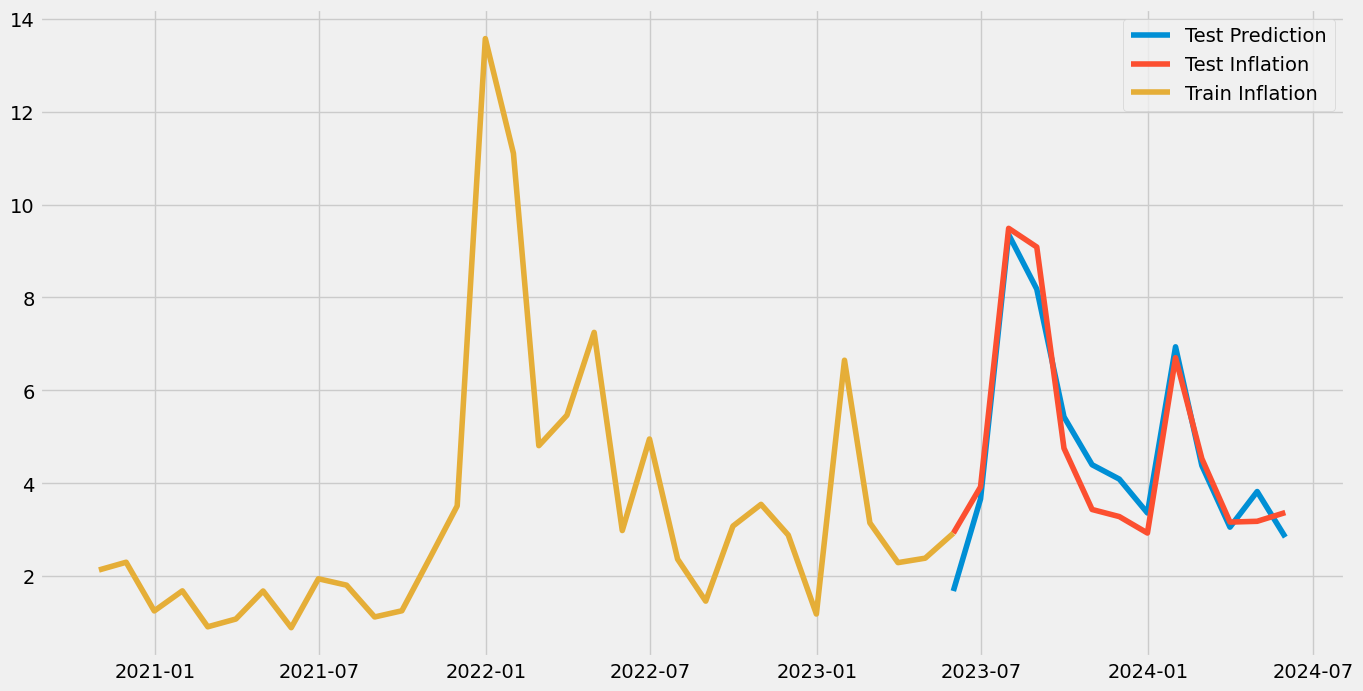

In [44]:
plt.figure(figsize=(15,8))
plt.plot(pd.DataFrame(scaler2.inverse_transform(np.array(model.predict(scaled_data.iloc[-14:-1,:-1])).reshape(-1,1))).set_index(data1.index[-14:-1]),label="Test Prediction")
plt.plot(data["TÜFE"].iloc[-14:-1],label="Test Inflation")
plt.plot(data["TÜFE"].iloc[-45:-13],label="Train Inflation")

plt.legend()

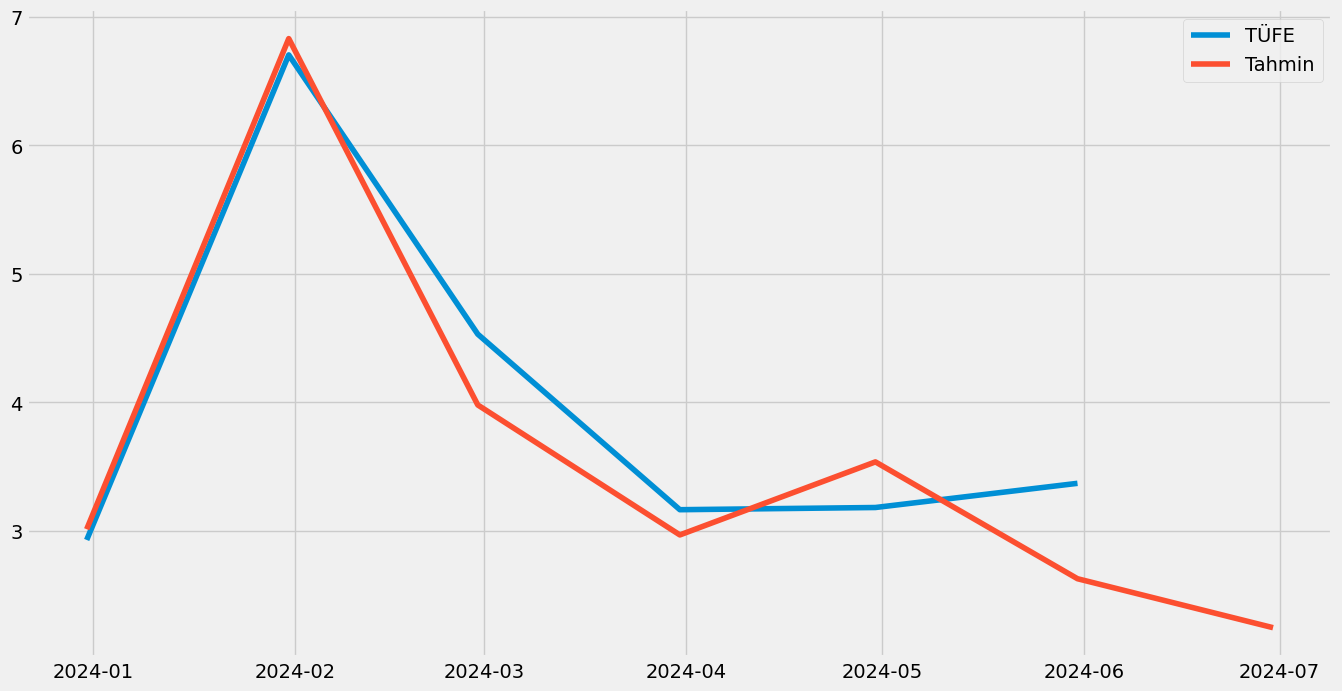

In [45]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"].iloc[:-1],label="TÜFE")
plt.plot(tahminler["NN1"],label="Tahmin")
plt.legend()

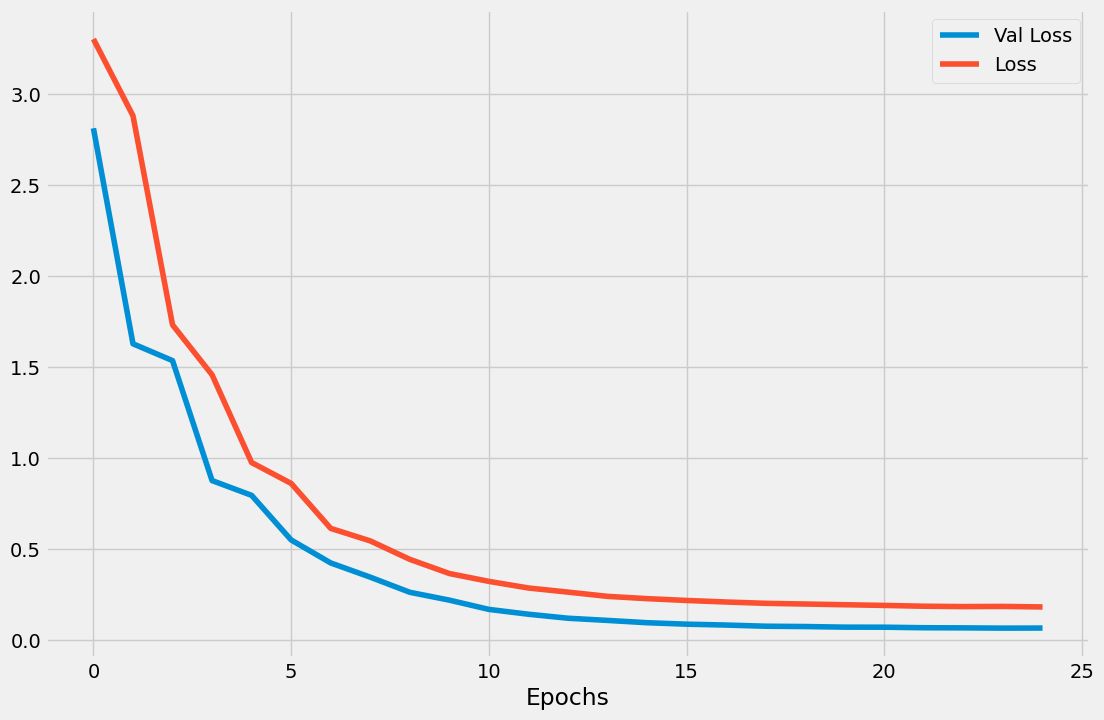

In [46]:
plt.figure(figsize=(12,8))
plt.plot(history.history["val_loss"],label="Val Loss")
plt.plot(history.history["loss"],label="Loss")
plt.xlabel("Epochs")
plt.legend()

In [47]:
kısatahminler=pd.concat([tahminler.iloc[-7:],tahminler2.iloc[-7:,1],tahminler3.iloc[-7:,1],tahminler4.iloc[-7:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,Ortalama
2023-12-31,2.927207,3.010675,3.340102,3.142150,3.358811,3.212935
2024-01-31,6.703310,6.830270,6.837417,4.899003,6.937675,6.376091
2024-02-29,4.529188,3.978037,4.260104,3.818145,4.380619,4.109226
2024-03-31,3.162671,2.966294,2.839868,2.840027,3.053555,2.924936
2024-04-30,3.179759,3.534941,3.996898,3.685938,3.820766,3.759636
2024-05-31,3.368063,2.625304,2.923874,2.778111,2.838772,2.791515
2024-06-30,0.000000,2.244194,2.116495,2.125612,2.082666,2.142242


## Orta Vadeli Tahminler

In [26]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-04-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.000000
2024-09-30,50.000000
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000
2025-01-31,50.000000


In [27]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [28]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.897922
2007-08-31,94.606608
2007-10-31,98.111410
2007-11-30,110.422510
2007-12-31,107.237150
...,...
2023-11-30,2372.262380
2024-01-31,2403.605577
2024-02-29,2542.824291
2024-04-30,2888.414877


In [29]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [30]:
faiztahmin.columns=["Faiz"]


In [31]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [38]:
exog=pfaiz["Faiz"].iloc[36:-3]
exog=np.array(exog).reshape(-1,1)

In [39]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [40]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-05-31,8.458733
2024-06-30,8.444408
2024-07-31,8.435135
2024-08-31,8.421754
2024-09-30,8.418178
2024-10-31,8.416087
2024-11-30,8.413071
2024-12-31,8.412265
2025-01-31,8.411794
2025-02-28,8.411114


In [41]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [42]:
import optuna


In [43]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.50,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=usd.index\n    sn["y"]=usd.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],sea

In [44]:
"""study.best_params"""

'study.best_params'

In [223]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.828175414699565,changepoint_range=0.950080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

00:40:37 - cmdstanpy - INFO - Chain [1] start processing
00:40:48 - cmdstanpy - INFO - Chain [1] done processing


In [224]:
(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()

ds
2024-07-31    1.913216
2024-08-31    1.863913
2024-09-30    1.798472
2024-10-31    1.763794
2024-11-30    1.738449
2024-12-31    1.705314
2025-01-31    1.702618
2025-02-28    1.597129
2025-03-31    1.572325
2025-04-30    1.595190
2025-05-31    1.574354
2025-06-30    1.549153
2025-07-31    1.523012
2025-08-31    1.530689
2025-09-30    1.476257
2025-10-31    1.457517
2025-11-30    1.061841
Freq: ME, Name: yhat, dtype: float64

In [225]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()
usdtahmin

ds
2024-07-31    1.913216
2024-08-31    1.863913
2024-09-30    1.798472
2024-10-31    1.763794
2024-11-30    1.738449
2024-12-31    1.705314
2025-01-31    1.702618
2025-02-28    1.597129
2025-03-31    1.572325
2025-04-30    1.595190
2025-05-31    1.574354
2025-06-30    1.549153
2025-07-31    1.523012
2025-08-31    1.530689
2025-09-30    1.476257
2025-10-31    1.457517
2025-11-30    1.061841
Freq: ME, Name: yhat, dtype: float64

In [226]:
usd_aylık=usd.resample('M').mean().dropna()

In [227]:
usdtahmin1 = []
result = usd_aylık.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,31.986743
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.782400
2024-08-31,33.409598
2024-09-30,34.032324
2024-10-31,34.644386
2024-11-30,35.255442
2024-12-31,35.868340


In [50]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [51]:
"""study.best_params"""

'study.best_params'

In [52]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=9.333547662504625,changepoint_range=0.9362159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:05 - cmdstanpy - INFO - Chain [1] done processing


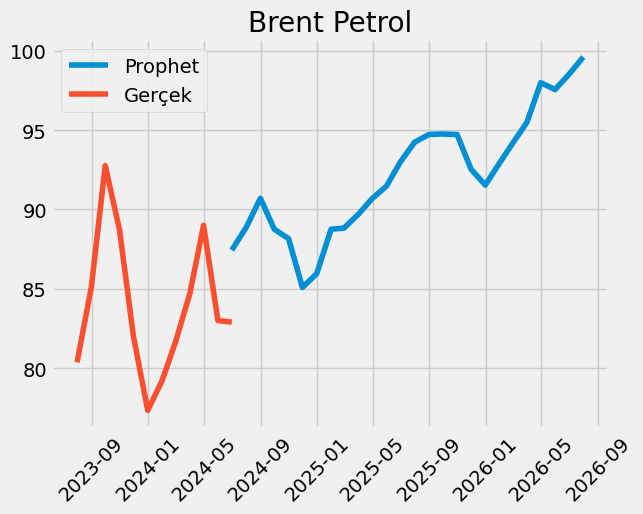

In [53]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [54]:
brenttahmin=predictions["yhat"][-29:]
brenttahmin

ds
2024-03-31    83.930640
2024-04-30    83.380709
2024-05-31    85.351352
2024-06-30    87.437215
2024-07-31    88.850020
2024-08-31    90.701910
2024-09-30    88.751290
2024-10-31    88.158212
2024-11-30    85.077764
2024-12-31    85.952230
2025-01-31    88.749942
2025-02-28    88.822545
2025-03-31    89.686915
2025-04-30    90.681921
2025-05-31    91.468749
2025-06-30    92.986884
2025-07-31    94.240039
2025-08-31    94.727138
2025-09-30    94.754468
2025-10-31    94.717600
2025-11-30    92.538697
2025-12-31    91.534189
2026-01-31    92.931679
2026-02-28    94.162260
2026-03-31    95.483223
2026-04-30    97.988779
2026-05-31    97.556858
2026-06-30    98.509268
2026-07-31    99.605630
Name: yhat, dtype: float64

In [55]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:06 - cmdstanpy - INFO - Chain [1] done processing


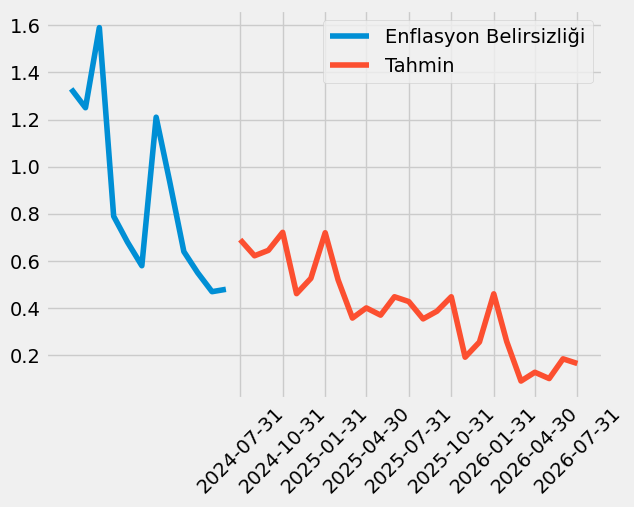

In [56]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=1.7,changepoint_range=0.91,seasonality_prior_scale=0.1053403857042852,n_changepoints=44,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [57]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-06-30,0.480000
2024-07-31,0.690676
2024-08-31,0.622271
2024-09-30,0.645261
2024-10-31,0.721728
2024-11-30,0.461565
2024-12-31,0.526547
2025-01-31,0.719879
2025-02-28,0.519855


In [58]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [59]:
#study.best_params

In [229]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-04-30   -0.655221
2024-05-31    2.363427
2024-06-30    2.443855
2024-07-31    1.615794
2024-08-31    2.084288
2024-09-30   -2.150583
2024-10-31   -0.668247
2024-11-30   -3.494227
2024-12-31    1.027843
2025-01-31    3.254961
2025-02-28    0.081806
2025-03-31    0.973143
2025-04-30    1.109421
2025-05-31    0.867679
2025-06-30    1.659731
2025-07-31    1.347669
2025-08-31    0.516870
2025-09-30    0.028852
2025-10-31   -0.038909
2025-11-30   -2.300420
2025-12-31   -1.085501
2026-01-31    1.526741
2026-02-28    1.324178
2026-03-31    1.402859
2026-04-30    2.624080
2026-05-31   -0.440787
2026-06-30    0.976262
2026-07-31    1.112953
Name: yhat, dtype: float64

In [230]:
(usdtahmin1[:-5].pct_change(periods=1)*100).dropna()

,USD/TL
2024-04-30,1.071456
2024-05-31,-0.252354
2024-06-30,0.847663
2024-07-31,0.803059
2024-08-31,1.913216
2024-09-30,1.863913
2024-10-31,1.798472
2024-11-30,1.763794
2024-12-31,1.738449
2025-01-31,1.705314


In [331]:
(brenttahmin1[:-7]).dropna()

ds
2024-04-30   -0.655221
2024-05-31    2.363427
2024-06-30    2.443855
2024-07-31    1.615794
2024-08-31    2.084288
2024-09-30   -2.150583
2024-10-31   -0.668247
2024-11-30   -3.494227
2024-12-31    1.027843
2025-01-31    3.254961
2025-02-28    0.081806
2025-03-31    0.973143
2025-04-30    1.109421
2025-05-31    0.867679
2025-06-30    1.659731
2025-07-31    1.347669
2025-08-31    0.516870
2025-09-30    0.028852
2025-10-31   -0.038909
2025-11-30   -2.300420
2025-12-31   -1.085501
Name: yhat, dtype: float64

In [332]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-7]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-04-28",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2024-04-30,-3.259186
2024-05-31,2.105109
2024-06-30,3.312234
2024-07-31,2.431828
2024-08-31,4.037381
2024-09-30,-0.326755
2024-10-31,1.118207
2024-11-30,-1.792064
2024-12-31,2.784161
2025-01-31,5.015783


In [ ]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [74]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.7034897796889,changepoint_range=0.88529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

00:32:07 - cmdstanpy - INFO - Chain [1] start processing
00:32:07 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
paraarzitahmin=(predictions["yhat"]).tail(25)
paraarzitahmin

ds
2024-07-31    3.504662
2024-08-31    2.393968
2024-09-30    3.825973
2024-10-31    3.714289
2024-11-30    3.412733
2024-12-31    3.497361
2025-01-31    2.091410
2025-02-28    2.443624
2025-03-31    4.169802
2025-04-30    3.729371
2025-05-31    3.346877
2025-06-30    3.784292
2025-07-31    3.059714
2025-08-31    3.085059
2025-09-30    3.270846
2025-10-31    3.022078
2025-11-30    3.014709
2025-12-31    3.738895
2026-01-31    1.900086
2026-02-28    2.515017
2026-03-31    3.940061
2026-04-30    2.928825
2026-05-31    3.190663
2026-06-30    3.860581
2026-07-31    2.622084
Name: yhat, dtype: float64

In [76]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-07-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-01-31",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-01-31,1.009923
2024-02-29,1.024741
2024-03-31,1.049300
2024-04-30,1.070100
2024-05-31,1.089998
2024-06-30,1.124731
2024-07-31,1.164149
2024-08-31,1.192018
2024-09-30,1.237625
2024-10-31,1.283594


In [77]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [78]:
#study.best_params

In [79]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [80]:
"""study.best_params"""

'study.best_params'

In [81]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.8099759561372614,changepoint_range=0.952589785485153,growth="linear",seasonality_prior_scale=3.534157847860739,n_changepoints=189,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

00:32:08 - cmdstanpy - INFO - Chain [1] start processing
00:32:08 - cmdstanpy - INFO - Chain [1] done processing


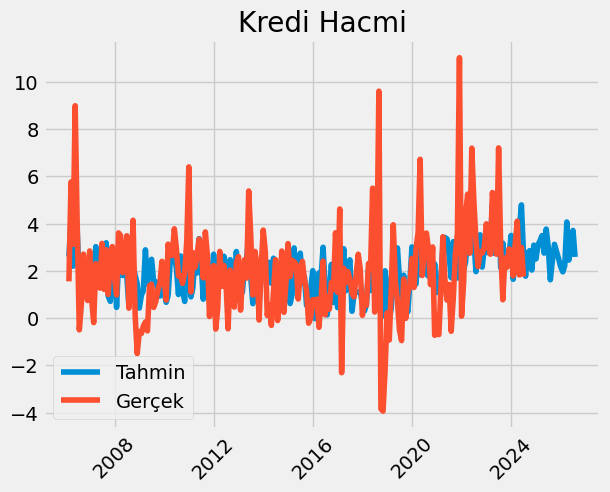

In [82]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [83]:
kreditahmin=(predictions["yhat"]).tail(25)
kreditahmin

ds
2024-07-31    1.779440
2024-08-31    2.755549
2024-09-30    2.861382
2024-10-31    2.038792
2024-11-30    3.092548
2024-12-31    2.508807
2025-01-31    3.109705
2025-02-28    3.269588
2025-03-31    3.497410
2025-04-30    2.754214
2025-05-31    3.772817
2025-06-30    3.015215
2025-07-31    1.626821
2025-08-31    2.470655
2025-09-30    3.127889
2025-10-31    2.816508
2025-11-30    2.513320
2025-12-31    2.171383
2026-01-31    1.963182
2026-02-28    2.219667
2026-03-31    4.072015
2026-04-30    2.461776
2026-05-31    3.244855
2026-06-30    3.713963
2026-07-31    2.592847
Name: yhat, dtype: float64

In [84]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-07-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-03-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-03-31,4.108658
2024-04-30,1.832087
2024-05-31,2.996531
2024-06-30,1.758207
2024-07-31,1.779440
2024-08-31,2.755549
2024-09-30,2.861382
2024-10-31,2.038792
2024-11-30,3.092548
2024-12-31,2.508807


In [85]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [328]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=18,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

00:44:57 - cmdstanpy - INFO - Chain [1] start processing
00:44:57 - cmdstanpy - INFO - Chain [1] done processing


In [329]:
m3tahmin=(predictions["yhat"].tail(18))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-07-31", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-03-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-03-31,2.687835
2024-04-30,2.405048
2024-05-31,3.532013
2024-06-30,3.568429
2024-07-31,3.016723
2024-08-31,1.990389
2024-09-30,3.206411
2024-10-31,3.392799
2024-11-30,2.982850
2024-12-31,2.223126


In [89]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [90]:
#study.best_params

In [91]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [333]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1.shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.shift(1)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]




tahmindf=tahmindf[['USD/TL', 'Motorin', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','İşsizlik','Politika Faizi']



tahmindf=tahmindf.loc["2024-06-30":]
tahmindf["Motorin"].iloc[0]=-1.61
tahmindf

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,İşsizlik,Politika Faizi
2024-06-30,0.553511,-1.610000,0.0,0.480000,1.859475,3.532013,2.195608,8.444408,50.106471
2024-07-31,0.466467,2.431828,0.0,0.690676,3.186526,3.568429,2.178059,8.435135,50.000000
2024-08-31,1.190875,4.037381,0.0,0.622271,3.504662,3.016723,2.097732,8.421754,50.000000
2024-09-30,1.530787,-0.326755,0.0,0.645261,2.393968,1.990389,2.465457,8.418178,50.000000
2024-10-31,1.857819,1.118207,0.0,0.721728,3.825973,3.206411,2.551908,8.416087,50.000000
2024-11-30,1.808120,-1.792064,0.0,0.461565,3.714289,3.392799,2.664241,8.413071,50.000000
2024-12-31,1.766552,2.784161,0.0,0.526547,3.412733,2.982850,2.546716,8.412265,50.000000
2025-01-31,1.735514,5.015783,30.0,0.719879,3.497361,2.223126,2.903687,8.411794,50.000000
2025-02-28,1.715257,1.785817,0.0,0.519855,2.091410,1.227532,2.962700,8.411114,50.000000
2025-03-31,1.667743,2.585815,0.0,0.358107,2.443624,1.756504,3.292234,8.410932,50.000000


In [334]:
data["TÜFE Lag"]=(enf.pct_change()*100).shift(1).dropna()["TÜFE"]
tahmindf["TÜFE Lag"]=0
tahmindf["TÜFE Lag"].iloc[0]=data["TÜFE"].iloc[-1]

In [335]:
data.loc["2023-06-30","TÜFE Lag"]=data.loc["2023-05-31","TÜFE"]

In [336]:
data=data.dropna()

In [337]:
data1=pd.concat([data,tahmindf],axis=0)
data1

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,...,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE,TÜFE Lag
2014-01-31,3.732429,2.881984,3.413428,0.370000,5.265777,0.460607,3.375162,2.886648,-7.844611,7.652883,...,1.06,9.200000,7.503636,0.618013,1.776282,1.106494,0.625859,0.333618,1.978080,0.460607
2014-02-28,3.033477,1.685899,1.958423,0.310000,0.000000,1.978080,1.804994,2.214819,-6.175956,-14.641565,...,0.69,9.500000,10.070500,1.106494,0.625859,3.319203,-0.111246,1.009554,0.428192,1.978080
2014-03-31,2.465778,-2.278097,0.229599,0.160000,0.000000,0.428192,0.451349,1.160171,4.991889,-6.505852,...,0.65,9.500000,10.200952,3.319203,-0.111246,1.383675,0.308798,0.989257,1.125608,0.428192
2014-04-30,-1.344724,-6.214384,0.730196,0.230000,0.000000,1.125608,0.796760,0.126575,12.575902,13.043316,...,0.76,9.700000,10.046190,1.383675,0.308798,0.736212,0.701489,2.649799,1.344970,1.125608
2014-05-31,-1.859714,-0.561578,-0.093468,0.260000,0.000000,1.344970,-0.362357,0.464970,-7.919312,0.662228,...,0.63,9.700000,9.891000,0.736212,0.701489,0.085477,1.197755,0.211698,0.395224,1.344970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31,1.548574,2.047754,2.093279,0.354611,0.000000,NaN,3.059714,2.370897,NaN,NaN,...,NaN,8.627526,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2025-09-30,1.534191,1.559982,1.970193,0.387088,0.000000,NaN,3.085059,2.408455,NaN,NaN,...,NaN,8.627517,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2025-10-31,1.509749,1.436774,2.068771,0.448417,0.000000,NaN,3.270846,2.805017,NaN,NaN,...,NaN,8.627512,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2025-11-30,1.487790,-0.876432,2.047671,0.192135,0.000000,NaN,3.022078,2.819239,NaN,NaN,...,NaN,8.627504,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [338]:
features=['USD/TL','Motorin','M3','Enflasyon Belirsizliği', 'Kredi','İşsizlik','TÜFE']
data1=data1[features]


In [339]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Kredi,İşsizlik,TÜFE
1,0.271479,-0.042393,-0.155072,-0.560211,0.128102,-0.746749,-0.654105
2,0.090320,-0.613230,-0.863880,-0.964469,-0.627083,-0.746749,-0.344878
3,-1.125645,-1.180077,-0.658638,-0.775816,-1.367193,-0.625425,-0.247614
4,-1.289984,-0.366042,-0.996335,-0.694964,-1.124885,-0.625425,-0.668723
5,-1.202579,0.110798,-1.165081,-0.533261,-0.668313,-0.625425,-0.706160
...,...,...,...,...,...,...,...
139,-0.202368,0.009716,-0.099783,-0.439983,0.239862,-1.276008,NaN
140,-0.206958,-0.060526,-0.150247,-0.352456,0.266756,-1.276013,NaN
141,-0.214757,-0.078268,-0.109831,-0.187170,0.550716,-1.276017,NaN
142,-0.221765,-0.411383,-0.118481,-0.877864,0.560899,-1.276021,NaN


In [340]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:-14,:-1]
y=scaled_data["TÜFE"][:-14]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-12,:],X.iloc[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)


In [100]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 128)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    rlrate2=trial.suggest_float('rlrate2',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate2)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)  

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))

    return mse  # Return validation accuracy as the objective


In [101]:
"""study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

"study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective\nstudy.optimize(objective, n_trials=2000)  # You can adjust the number of trials\n\n# Print the best hyperparameters\nprint('Best hyperparameters:', study.best_params)"

In [345]:
from sklearn.model_selection import train_test_split
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3','Enflasyon Belirsizliği', 'Kredi','İşsizlik','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-21,:-1]
y=scaled_data["TÜFE"][:-21]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)

In [346]:
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=3,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.11064517951376238)))
model.add(Dense(units=3,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7726924049252087)))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.025721829128366083)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=3,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.3555 - mean_squared_error: 0.4564 - val_loss: 0.5931 - val_mean_squared_error: 0.1839
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5823 - mean_squared_error: 0.2645 - val_loss: 0.3924 - val_mean_squared_error: 0.1099
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4626 - mean_squared_error: 0.2014 - val_loss: 0.3547 - val_mean_squared_error: 0.1057
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4183 - mean_squared_error: 0.1857 - val_loss: 0.3610 - val_mean_squared_error: 0.0978


In [347]:
pred1=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [348]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


0.8040624986600381

In [351]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-19:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=19,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


,TÜFE
2024-06-30,2.090404
2024-07-31,3.073324
2024-08-31,3.037185
2024-09-30,2.662317
2024-10-31,3.217009
2024-11-30,2.461182
2024-12-31,2.883359
2025-01-31,3.415014
2025-02-28,2.553664
2025-03-31,2.392932


In [352]:
tüfetahmin1 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["NN"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

,NN
2024-06-30,2329.549874
2024-07-31,2401.144499
2024-08-31,2474.071693
2024-09-30,2539.939331
2024-10-31,2621.649410
2024-11-30,2686.172976
2024-12-31,2763.624979
2025-01-31,2858.003159
2025-02-28,2930.986970
2025-03-31,3001.123486


In [353]:
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-21,:-1]
y=scaled_data["TÜFE"][:-21]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=3,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7756667258232616)))
model.add(Dense(units=113,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.22481422283704167)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.04592122323666263)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=50, batch_size=60,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - loss: 16.9187 - mean_squared_error: 12.2703 - val_loss: 15.1503 - val_mean_squared_error: 11.4741
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 13.4627 - mean_squared_error: 9.7848 - val_loss: 5.3950 - val_mean_squared_error: 2.5763
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.6599 - mean_squared_error: 1.9023 - val_loss: 2.6188 - val_mean_squared_error: 0.2569
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.7295 - mean_squared_error: 0.4299 - val_loss: 2.1943 - val_mean_squared_error: 0.2296
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.3150 - mean_squared_error: 0.4039 - val_loss: 1.8484 - val_mean_squared_error: 0.2126
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.9795 - mean_squared_error: 0.3890 - val_loss: 1.5686 - val_mean_squared_error: 0.2011
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.7098 - mean_squared_error: 0.3813 - val_loss: 1.3424 - val_mean_s

In [354]:
mean_squared_error(scaler.inverse_transform(y_test).reshape(-1,1),scaler.inverse_transform(model.predict(X_test)).reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


0.639071534127401

In [355]:
pred2=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [111]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-30",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test).reshape(-1,1)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test)).reshape(-1,1)
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,3.408810
2023-05-31,2.923076,2.953272
2023-06-30,3.920498,4.549405
2023-07-31,9.488824,10.336913
2023-08-31,9.086793,8.419420
2023-09-30,4.753114,5.418151
2023-10-31,3.433981,3.377148
2023-11-30,3.281097,3.086969
2023-12-31,2.927207,2.765540
2024-01-31,6.703310,4.615154


In [356]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-19:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=19,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


,TÜFE
2024-06-30,3.064491
2024-07-31,2.846443
2024-08-31,2.889233
2024-09-30,2.076443
2024-10-31,2.713435
2024-11-30,2.394848
2024-12-31,2.883529
2025-01-31,3.107737
2025-02-28,2.303808
2025-03-31,2.744903


In [357]:
tüfetahmin4 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin4.append(result)

tüfetahmin4 = np.array(tüfetahmin4).reshape(-1, 1)
tüfetahmin4 = pd.DataFrame(tüfetahmin4)
tüfetahmin4.columns = ["NN"]
tüfetahmin4 = tüfetahmin4.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin4), freq="1M"))
tüfetahmin4

,NN
2024-06-30,2351.777083
2024-07-31,2418.719076
2024-08-31,2488.601503
2024-09-30,2540.275893
2024-10-31,2609.204621
2024-11-30,2671.691102
2024-12-31,2748.730101
2025-01-31,2834.153412
2025-02-28,2899.446878
2025-03-31,2979.033891


In [358]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3', 'Kredi','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-21,:-1]
y=scaled_data["TÜFE"][:-21]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=48,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7094881423211541)))
model.add(Dense(units=77,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.7574422111330262)))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.05310522650503496)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=58,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 55.5185 - mean_squared_error: 8.9592 - val_loss: 22.4179 - val_mean_squared_error: 1.0792
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 20.8023 - mean_squared_error: 1.5273 - val_loss: 11.8515 - val_mean_squared_error: 0.4533
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 11.9256 - mean_squared_error: 0.7271 - val_loss: 10.9823 - val_mean_squared_error: 0.1737
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 11.8230 - mean_squared_error: 0.9311 - val_loss: 11.5748 - val_mean_squared_error: 0.5677


In [359]:
pred3=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [360]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


0.8218924151059649

In [361]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-19:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=19,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


,TÜFE
2024-06-30,2.642072
2024-07-31,1.932425
2024-08-31,2.165944
2024-09-30,1.328289
2024-10-31,1.938168
2024-11-30,1.581391
2024-12-31,2.106614
2025-01-31,2.237195
2025-02-28,1.462587
2025-03-31,1.725560


In [362]:
tüfetahmin3 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin3.append(result)

tüfetahmin3 = np.array(tüfetahmin3).reshape(-1, 1)
tüfetahmin3 = pd.DataFrame(tüfetahmin3)
tüfetahmin3.columns = ["NN"]
tüfetahmin3 = tüfetahmin3.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin3), freq="1M"))
tüfetahmin3

,NN
2024-06-30,2342.138125
2024-07-31,2387.398182
2024-08-31,2439.107886
2024-09-30,2471.506295
2024-10-31,2519.408240
2024-11-30,2559.249947
2024-12-31,2613.163455
2025-01-31,2671.625030
2025-02-28,2710.699870
2025-03-31,2757.474622


In [363]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','ParaArzi', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-21,:-1]
y=scaled_data["TÜFE"][:-21]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=89,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.05688977475972332)))
model.add(Dense(units=18,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.6706865688008817)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.01985884761094969)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=57,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - loss: 25.8370 - mean_squared_error: 7.5789 - val_loss: 12.8421 - val_mean_squared_error: 2.2095
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.1307 - mean_squared_error: 2.4186 - val_loss: 6.4437 - val_mean_squared_error: 0.4154
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.0595 - mean_squared_error: 0.4455 - val_loss: 3.9153 - val_mean_squared_error: 0.1219
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.9013 - mean_squared_error: 0.3264 - val_loss: 2.7277 - val_mean_squared_error: 0.1444
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.7855 - mean_squared_error: 0.3442 - val_loss: 1.9941 - val_mean_squared_error: 0.1553
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.0947 - mean_squared_error: 0.3574 - val_loss: 1.5308 - val_mean_squared_error: 0.1694
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.6471 - mean_squared_error: 0.3652 - val_loss: 1.2374 

In [364]:
pred4=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [365]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


0.7713515636869754

In [122]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-30",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[1,:]-=2.88
tahminler.iloc[-3,1]=6.83
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,2.851760
2023-05-31,0.043076,-0.630743
2023-06-30,3.920498,3.948094
2023-07-31,9.488824,10.500203
2023-08-31,9.086793,9.126779
2023-09-30,4.753114,6.256603
2023-10-31,3.433981,3.381956
2023-11-30,3.281097,2.850476
2023-12-31,2.927207,2.344928
2024-01-31,6.703310,6.830000


In [366]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-19:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=19,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


,TÜFE
2024-06-30,2.306112
2024-07-31,2.128574
2024-08-31,2.657679
2024-09-30,1.549166
2024-10-31,2.441682
2024-11-30,1.893809
2024-12-31,2.529509
2025-01-31,2.919210
2025-02-28,1.816765
2025-03-31,2.110931


In [367]:
tüfetahmin2= []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["NN"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin2), freq="1M"))
tüfetahmin2

,NN
2024-06-30,2334.472007
2024-07-31,2384.162963
2024-08-31,2447.526363
2024-09-30,2485.442612
2024-10-31,2546.129207
2024-11-30,2594.348042
2024-12-31,2659.972305
2025-01-31,2737.622494
2025-02-28,2787.358654
2025-03-31,2846.197863


In [368]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','ParaArzi', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-21,:-1]
y=scaled_data["TÜFE"][:-21]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=15,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1761578686433001)))
model.add(Dense(units=13,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.11029211327374655)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.02714594119301986)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=62,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - loss: 6.4496 - mean_squared_error: 3.3959 - val_loss: 2.6479 - val_mean_squared_error: 0.2056
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.7409 - mean_squared_error: 0.3766 - val_loss: 2.6157 - val_mean_squared_error: 0.6195
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.6343 - mean_squared_error: 0.7030 - val_loss: 1.8481 - val_mean_squared_error: 0.2047
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.9588 - mean_squared_error: 0.3609 - val_loss: 1.5453 - val_mean_squared_error: 0.1638
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.6610 - mean_squared_error: 0.3179 - val_loss: 1.3381 - val_mean_squared_error: 0.1670
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4618 - mean_squared_error: 0.3250 - val_loss: 1.1758 - val_mean_squared_error: 0.1778
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.3035 - mean_squared_error: 0.3365 - val_loss: 1.0295 - v

In [369]:
pred5=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [370]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


0.753973287250738

In [128]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-28",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[1,:]-=2.88
tahminler.iloc[-3,1]=6.83
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,3.147883
2023-05-31,0.043076,-0.405418
2023-06-30,3.920498,4.259540
2023-07-31,9.488824,10.396959
2023-08-31,9.086793,9.090839
2023-09-30,4.753114,6.317866
2023-10-31,3.433981,3.459221
2023-11-30,3.281097,3.024334
2023-12-31,2.927207,2.419559
2024-01-31,6.703310,6.830000


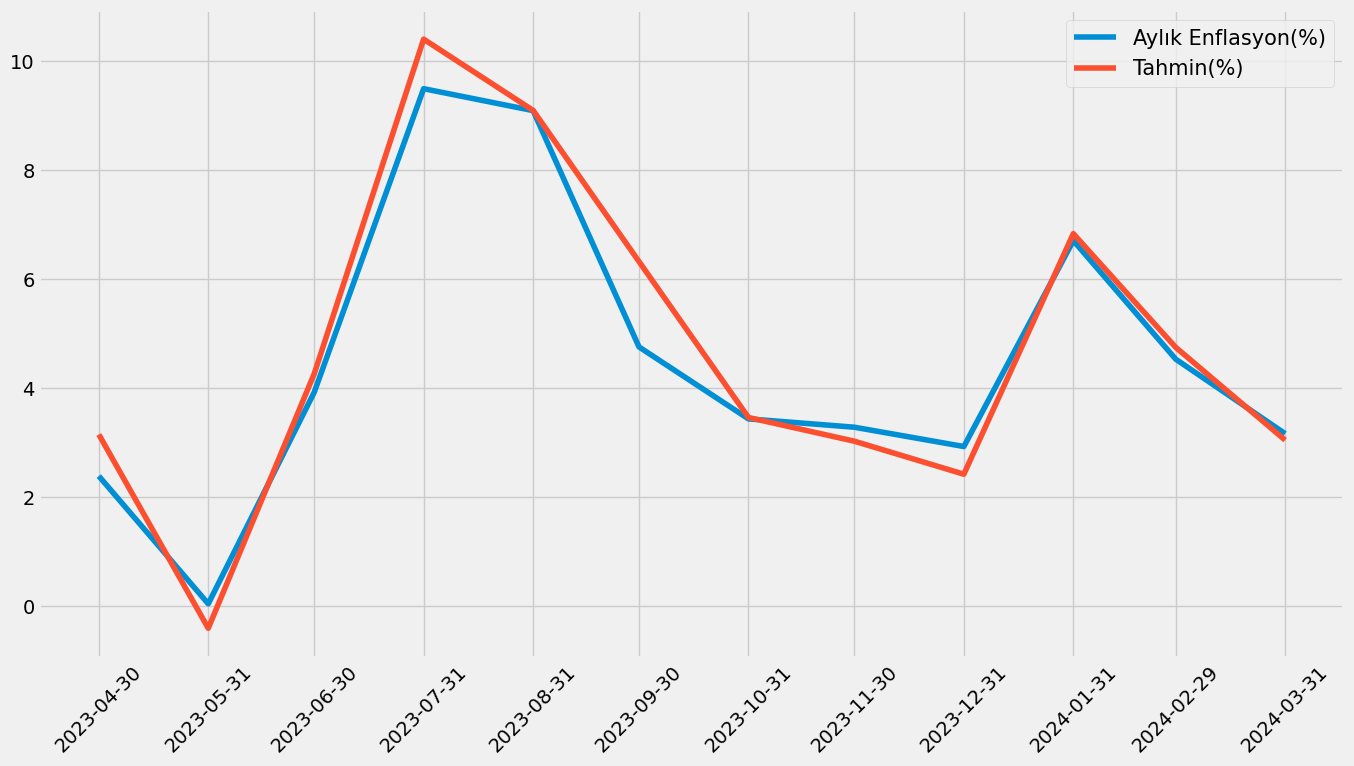

In [129]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"],label="Aylık Enflasyon(%)")
plt.plot(tahminler["Tahmin"],label="Tahmin(%)")
plt.xticks(tahminler.index,rotation=45)
plt.legend(fontsize=15)
plt.show()

In [371]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-19:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=19,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


,TÜFE
2024-06-30,2.281603
2024-07-31,2.065025
2024-08-31,2.638501
2024-09-30,1.623780
2024-10-31,2.556646
2024-11-30,2.022425
2024-12-31,2.624039
2025-01-31,3.065949
2025-02-28,1.927204
2025-03-31,2.274027


In [372]:
tüfetahmin00 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin00.append(result)

tüfetahmin00 = np.array(tüfetahmin00).reshape(-1, 1)
tüfetahmin00 = pd.DataFrame(tüfetahmin00)
tüfetahmin00.columns = ["NN"]
tüfetahmin00 = tüfetahmin00.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin00), freq="1M"))
tüfetahmin00

,NN
2024-06-30,2333.912749
2024-07-31,2382.108639
2024-08-31,2444.960603
2024-09-30,2484.661379
2024-10-31,2548.185383
2024-11-30,2599.720526
2024-12-31,2667.938217
2025-01-31,2749.735848
2025-02-28,2802.728854
2025-03-31,2866.463668


In [373]:
data1=pd.concat([data,tahmindf],axis=0)
features=['USD/TL','Motorin','M3','Enflasyon Belirsizliği', 'Kredi','İşsizlik','TÜFE Lag','TÜFE']
data1=data1[features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data=scaled_data.iloc[1:,:]
X=scaled_data
X=X.iloc[:-21,:-1]
y=scaled_data["TÜFE"][:-21]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(Dense(units=1,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.5704018348571585)))
model.add(Dense(units=38,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.5507354626876133)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.023834321386068204)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=57,verbose=1,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - loss: 2.9950 - mean_squared_error: 0.7136 - val_loss: 1.7373 - val_mean_squared_error: 0.2960
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.9095 - mean_squared_error: 0.5409 - val_loss: 1.4071 - val_mean_squared_error: 0.2762
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.7390 - mean_squared_error: 0.6769 - val_loss: 1.0487 - val_mean_squared_error: 0.1732
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.2985 - mean_squared_error: 0.4669 - val_loss: 0.8756 - val_mean_squared_error: 0.1504
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.1047 - mean_squared_error: 0.4155 - val_loss: 0.7393 - val_mean_squared_error: 0.1236
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9639 - mean_squared_error: 0.3797 - val_loss: 0.6366 - val_mean_squared_error: 0.1042
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8588 - mean_squared_error: 0.3546 - val_loss: 0.5605 - v

In [374]:
pred6=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [375]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


0.7449371021755469

In [135]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-04-28",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[1,:]-=2.88
tahminler

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,TÜFE,Tahmin
2023-04-30,2.385509,2.739427
2023-05-31,0.043076,-0.445877
2023-06-30,3.920498,5.318930
2023-07-31,9.488824,9.884755
2023-08-31,9.086793,8.423642
2023-09-30,4.753114,6.510648
2023-10-31,3.433981,3.474724
2023-11-30,3.281097,3.039855
2023-12-31,2.927207,2.620985
2024-01-31,6.703310,5.066568


In [376]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-19:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-06-30",periods=19,freq="1M"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


,TÜFE
2024-06-30,2.440358
2024-07-31,2.903538
2024-08-31,2.875715
2024-09-30,2.256655
2024-10-31,3.014780
2024-11-30,2.009080
2024-12-31,2.693450
2025-01-31,3.173970
2025-02-28,2.035881
2025-03-31,1.867504


In [377]:
tüfetahmin000 = []
result = enf["TÜFE"].iloc[-1]
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin000.append(result)

tüfetahmin000 = np.array(tüfetahmin000).reshape(-1, 1)
tüfetahmin000 = pd.DataFrame(tüfetahmin000)
tüfetahmin000.columns = ["NN"]
tüfetahmin000 = tüfetahmin000.set_index(pd.date_range(start="2024-06-30", periods=len(tüfetahmin000), freq="1M"))
tüfetahmin000

,NN
2024-06-30,2337.535318
2024-07-31,2405.406533
2024-08-31,2474.579158
2024-09-30,2530.421884
2024-10-31,2606.708538
2024-11-30,2659.079409
2024-12-31,2730.700382
2025-01-31,2817.372006
2025-02-28,2874.730342
2025-03-31,2928.416042


In [378]:
oran=pd.Series([0.6,0.275,0.395,0.265,0.13])
oran=1/oran
oran.values

array([1.66666667, 3.63636364, 2.53164557, 3.77358491, 7.69230769])

In [379]:
tüfetahmin=pd.DataFrame()
tüfetahmin["NN1"]=tüfetahmin1["NN"]
tüfetahmin["NN2"]=tüfetahmin00["NN"]
tüfetahmin["NN3"]=tüfetahmin000["NN"]
tüfetahmin["NN4"]=tüfetahmin2["NN"]
tüfetahmin["NN5"]=tüfetahmin3["NN"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin["Ensemble"]=tüfetahmin["NN1"]*oran[0]+tüfetahmin["NN2"]*oran[1]+tüfetahmin["NN3"]*oran[2]+tüfetahmin["NN4"]*oran[3]+tüfetahmin["NN5"]*oran[4]
tüfetahmin["Ensemble"]=tüfetahmin["Ensemble"]/np.sum(oran)
tüfetahmin

,NN1,NN2,NN3,NN4,NN5,Ortalama,Ensemble
2024-06-30,2329.549874,2333.912749,2337.535318,2334.472007,2342.138125,2335.521615,2337.398767
2024-07-31,2401.144499,2382.108639,2405.406533,2384.162963,2387.398182,2392.044163,2389.318240
2024-08-31,2474.071693,2444.960603,2474.579158,2447.526363,2439.107886,2456.049141,2449.528520
2024-09-30,2539.939331,2484.661379,2530.421884,2485.442612,2471.506295,2502.394300,2490.346931
2024-10-31,2621.649410,2548.185383,2606.708538,2546.129207,2519.408240,2568.416156,2550.334446
2024-11-30,2686.172976,2599.720526,2659.079409,2594.348042,2559.249947,2619.714180,2597.791951
2024-12-31,2763.624979,2667.938217,2730.700382,2659.972305,2613.163455,2687.079868,2661.045421
2025-01-31,2858.003159,2749.735848,2817.372006,2737.622494,2671.625030,2766.871707,2734.457183
2025-02-28,2930.986970,2802.728854,2874.730342,2787.358654,2710.699870,2821.300938,2783.565157
2025-03-31,3001.123486,2866.463668,2928.416042,2846.197863,2757.474622,2879.935136,2838.817978


In [380]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [381]:
row=pd.DataFrame(((tüfetahmin.iloc[0,:]/enf["TÜFE"].iloc[-1])-1)*100)
row=row.T
row


,NN1,NN2,NN3,NN4,NN5,Ortalama,Ensemble
2024-06-30,2.090404,2.281603,2.440358,2.306112,2.642072,2.35211,2.434374


In [382]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin

,NN1,NN2,NN3,NN4,NN5,Ortalama,Ensemble
2024-06-30,2.090404,2.281603,2.440358,2.306112,2.642072,2.352110,2.434374
2024-07-31,3.073324,2.065025,2.903538,2.128574,1.932425,2.420125,2.221250
2024-08-31,3.037185,2.638501,2.875715,2.657679,2.165944,2.675744,2.519977
2024-09-30,2.662317,1.623780,2.256655,1.549166,1.328289,1.886980,1.666378
2024-10-31,3.217009,2.556646,3.014780,2.441682,1.938168,2.638347,2.408802
2024-11-30,2.461182,2.022425,2.009080,1.893809,1.581391,1.997263,1.860835
2024-12-31,2.883359,2.624039,2.693450,2.529509,2.106614,2.571490,2.434894
2025-01-31,3.415014,3.065949,3.173970,2.919210,2.237195,2.969463,2.758756
2025-02-28,2.553664,1.927204,2.035881,1.816765,1.462587,1.967176,1.795895
2025-03-31,2.392932,2.274027,1.867504,2.110931,1.725560,2.078268,1.984966


In [383]:
std=aylıktahmin.iloc[:,:-1].std(axis=1)
std

2024-06-30    0.182999
2024-07-31    0.471021
2024-08-31    0.294019
2024-09-30    0.496649
2024-10-31    0.449903
2024-11-30    0.282697
2024-12-31    0.257954
2025-01-31    0.397032
2025-02-28    0.354191
2025-03-31    0.247854
2025-04-30    0.332809
2025-05-31    0.337218
2025-06-30    0.272418
2025-07-31    0.301728
2025-08-31    0.200393
2025-09-30    0.198857
2025-10-31    0.282785
2025-11-30    0.276897
2025-12-31    0.243716
dtype: float64

In [384]:
aylıktahmin["Maksimum"]=aylıktahmin["Ensemble"]+std
aylıktahmin["Minimum"]=aylıktahmin["Ensemble"]-std
aylıktahmin

,NN1,NN2,NN3,NN4,NN5,Ortalama,Ensemble,Maksimum,Minimum
2024-06-30,2.090404,2.281603,2.440358,2.306112,2.642072,2.352110,2.434374,2.617373,2.251375
2024-07-31,3.073324,2.065025,2.903538,2.128574,1.932425,2.420125,2.221250,2.692272,1.750229
2024-08-31,3.037185,2.638501,2.875715,2.657679,2.165944,2.675744,2.519977,2.813996,2.225959
2024-09-30,2.662317,1.623780,2.256655,1.549166,1.328289,1.886980,1.666378,2.163027,1.169730
2024-10-31,3.217009,2.556646,3.014780,2.441682,1.938168,2.638347,2.408802,2.858704,1.958899
2024-11-30,2.461182,2.022425,2.009080,1.893809,1.581391,1.997263,1.860835,2.143532,1.578137
2024-12-31,2.883359,2.624039,2.693450,2.529509,2.106614,2.571490,2.434894,2.692847,2.176940
2025-01-31,3.415014,3.065949,3.173970,2.919210,2.237195,2.969463,2.758756,3.155789,2.361724
2025-02-28,2.553664,1.927204,2.035881,1.816765,1.462587,1.967176,1.795895,2.150086,1.441704
2025-03-31,2.392932,2.274027,1.867504,2.110931,1.725560,2.078268,1.984966,2.232820,1.737112


In [385]:
aylıktahmin[[ 'NN1','NN2','NN3','NN4','NN5', 'Ortalama','Ensemble']].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [386]:
tüfe=df["CPI"].iloc[-1]

In [387]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [388]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin14 = []
lassotahmin=aylıktahmin["NN1"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [389]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin15 = []
larstahmin=aylıktahmin["NN2"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [390]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin16 = []
larstahmin=aylıktahmin["NN3"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))


In [391]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin17 = []
larstahmin=aylıktahmin["NN4"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [392]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin18 = []
larstahmin=aylıktahmin["NN5"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))

In [393]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin19 = []
larstahmin=aylıktahmin["Ensemble"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin19.append(tüfe)
tüfetahmin19=pd.DataFrame(tüfetahmin19)
tüfetahmin19=tüfetahmin19.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin19),freq="1M"))
tüfetahmin19.columns=["CPI"]
tüfetahmin19=pd.concat([df["CPI"],tüfetahmin19["CPI"]],axis=0)
tüfetahmin19=pd.DataFrame((tüfetahmin19.pct_change(periods=12)*100).tail(38))

In [394]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))
tüfetahmin23


,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [395]:
tüfe=df["CPI"].iloc[-1]
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-06-30",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [396]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)

In [397]:
aylık1=aylıktahmin
aylık1=aylık1[["Ensemble"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]],axis=0)
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

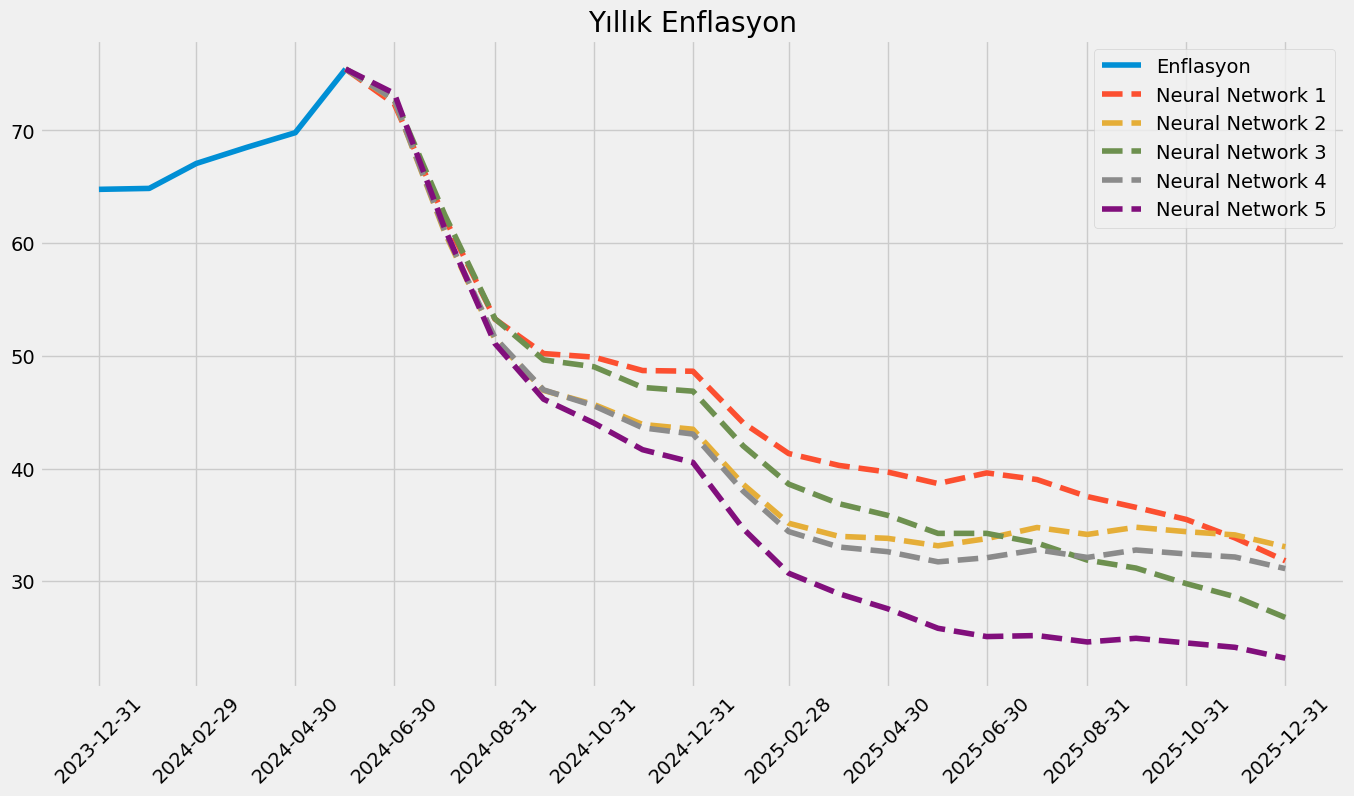

In [420]:
plt.style.use("fivethirtyeight")
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["NN1"]=tüfetahmin14["CPI"]
yıllıktahmin["NN2"]=tüfetahmin15["CPI"]
yıllıktahmin["NN3"]=tüfetahmin16["CPI"]
yıllıktahmin["NN4"]=tüfetahmin17["CPI"]
yıllıktahmin["NN5"]=tüfetahmin18["CPI"]
yıllıktahmin["Ensemble"]=tüfetahmin19["CPI"]
plt.figure(figsize=(15,8))
plt.plot(yıllıktahmin["Ortalama"].iloc[13:19],label="Enflasyon")
plt.plot(yıllıktahmin["NN1"].iloc[18:],'--',label="Neural Network 1")
plt.plot(yıllıktahmin["NN2"].iloc[18:],'--',label="Neural Network 2")
plt.plot(yıllıktahmin["NN3"].iloc[18:],'--',label="Neural Network 3")
plt.plot(yıllıktahmin["NN4"].iloc[18:],'--',label="Neural Network 4")
plt.plot(yıllıktahmin["NN5"].iloc[18:],'--',label="Neural Network 5")
plt.legend(loc=0)
plt.xticks(yıllıktahmin.index[13::2],rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [421]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

,Ortalama,NN1,NN2,NN3,NN4,NN5,Ensemble,Maksimum,Minimum
2022-11-30,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260
2022-12-31,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597
2023-01-31,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481
2023-02-28,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828
2023-03-31,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511
2023-04-30,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170
2023-05-31,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301
2023-06-30,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519
2023-07-31,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733
2023-08-31,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534


In [422]:
yıllıktahmin1=yıllıktahmin[['Ortalama','NN1','NN2','NN3','NN4','NN5','Ensemble', 'Maksimum',
       'Minimum']]

yıllıktahmin1.columns=['Ortalama','NN1','NN2','NN3','NN4','NN5','Ensemble', 'Maksimum',
       'Minimum']
yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

In [423]:
sonu2023=str(yıllıktahmin.iloc[20,0])[:5]
tepe=str(yıllıktahmin.iloc[-14,0])[:5]
sonu2024=str(yıllıktahmin.iloc[-7,0])[:5]
max=str(yıllıktahmin.iloc[-8,0])[:5]
min=str(yıllıktahmin.iloc[-8,0])[:5]


In [447]:
sonu12024=str(yıllıktahmin.iloc[-13,-3])[:5]

In [448]:
min1=str(yıllıktahmin.iloc[-13,-1])[:2]
max1=str(yıllıktahmin.iloc[-13,-2])[:2]

In [426]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-06-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-04-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-04-30,43.52


In [427]:
enf1=enf._append({"TÜFE":2207.50*1.0304},ignore_index=True)
enf1=enf.set_index(pd.date_range(start="2006-01-31",freq="M",periods=len(enf)))
enf1

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-01-31,1984.02
2024-02-29,2073.88
2024-03-31,2139.47
2024-04-30,2207.50


In [428]:
params = {
    'series': "TP.BEK.S01.A.A",
    'startDate': "30-09-2023",
    'endDate': "31-05-2024",
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

caritüfe = formatted_response['items']
caritüfe = pd.DataFrame(caritüfe)


caritüfe = caritüfe.drop(columns=['UNIXTIME','Tarih'])
caritüfe.columns = ['Beklenti']
caritüfe['Beklenti'] = pd.to_numeric(caritüfe['Beklenti'])
caritüfe["Beklenti"]=1+(caritüfe["Beklenti"]/100)
caritüfe=caritüfe.set_index(pd.date_range(start="2023-09-30",freq="M",periods=len(caritüfe)))
caritüfe["TÜFEt-1"]=enf["TÜFE"].shift(1).loc["2023-08-30":]
caritüfe["TÜFEt-12"]=enf["TÜFE"].loc["2022-09-30":"2023-05-31"].values
caritüfe["Tüfe Tahmin"]=caritüfe["Beklenti"]*caritüfe["TÜFEt-1"]
caritüfe["Enflasyon Tahmin"]=100*((caritüfe["Tüfe Tahmin"]/caritüfe["TÜFEt-12"])-1)
caritüfe

,Beklenti,TÜFEt-1,TÜFEt-12,Tüfe Tahmin,Enflasyon Tahmin
2023-09-30,1.0514,1614.31,1046.89,1697.285534,62.126444
2023-10-31,1.0430,1691.04,1084.00,1763.754720,62.708000
2023-11-30,1.0407,1749.11,1115.26,1820.298777,63.217436
2023-12-31,1.0329,1806.50,1128.45,1865.933850,65.353702
2024-01-31,1.0541,1859.38,1203.48,1959.972458,62.858748
2024-02-29,1.0389,1984.02,1241.33,2061.198378,66.047576
2024-03-31,1.0342,2073.88,1269.75,2144.806696,68.915668
2024-04-30,1.0330,2139.47,1300.04,2210.072510,70.000347
2024-05-31,1.0300,2207.50,1300.60,2273.725000,74.821236


In [467]:
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",end="2024-05-31",freq="M"))
geçmiş

,Tahmin
2023-09-30,61.94
2023-10-31,60.84
2023-11-30,62.13
2023-12-31,64.71
2024-01-31,65.06
2024-02-29,65.73
2024-03-31,69.47
2024-04-30,69.69
2024-05-31,74.65


In [430]:
tüfe=enf1["TÜFE"].iloc[-1]
piyasa=[tüfe,1.0304,1.0256,1.0234]
piyasa=np.cumprod(piyasa)
piyasa=piyasa[1:]
piyasa

array([2351.21824   , 2411.40942694, 2467.83640753])

In [431]:
piyasa=pd.DataFrame({"TÜFE":[2274.608,2332.8379,2387.4263,np.nan,np.nan,np.nan,np.nan,2670.81]})
piyasa.columns=["TÜFE"]
piyasa=piyasa.set_index(pd.date_range(start="2024-05-31",end="2024-12-31",freq="M"))
piyasa

,TÜFE
2024-05-31,2274.6080
2024-06-30,2332.8379
2024-07-31,2387.4263
2024-08-31,NaN
2024-09-30,NaN
2024-10-31,NaN
2024-11-30,NaN
2024-12-31,2670.8100


In [463]:
piyasa=pd.DataFrame({"TÜFE":[2274.608,2332.8379,2387.4263,np.nan,np.nan,np.nan,np.nan,2670.81,np.nan,np.nan,np.nan,np.nan,3039.65,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,3352.13]})
piyasa.columns=["TÜFE"]
piyasa=piyasa.set_index(pd.date_range(start="2024-05-31",end="2026-01-30",freq="M"))
piyasaenf=pd.concat([enf1["TÜFE"].iloc[:-1],piyasa["TÜFE"]],axis=0)
piyasaenf=pd.DataFrame(piyasaenf)
piyasaenf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2025-08-31,NaN
2025-09-30,NaN
2025-10-31,NaN
2025-11-30,NaN


In [464]:
piyasaenf.interpolate(method="linear", inplace=True)
piyasaenf.pct_change(12)*100

,TÜFE
2006-01-31,NaN
2006-02-28,NaN
2006-03-31,NaN
2006-04-30,NaN
2006-05-31,NaN
...,...
2025-08-31,29.845999
2025-09-30,28.688261
2025-10-31,27.581837
2025-11-30,26.523389


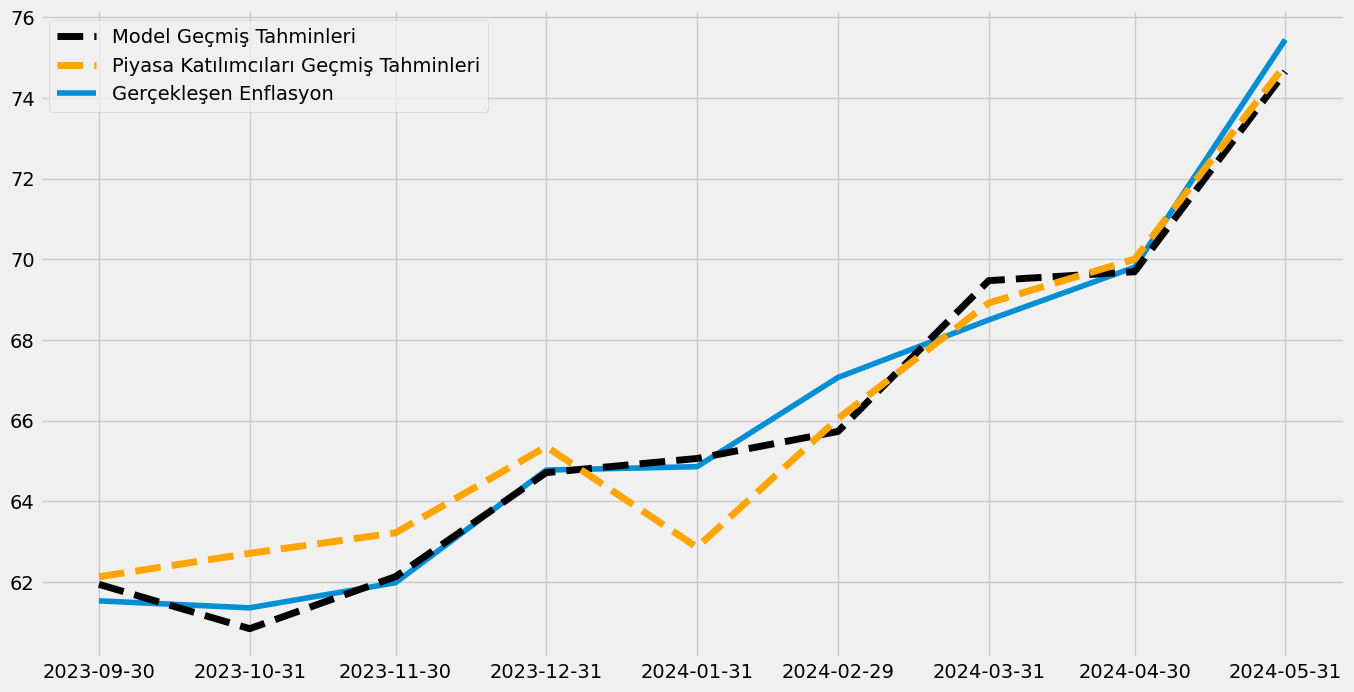

In [468]:
plt.figure(figsize=(15,8))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.plot(caritüfe["Enflasyon Tahmin"],'--',label="Piyasa Katılımcıları Geçmiş Tahminleri",color="orange",linewidth=5,zorder=3)
plt.plot((enf.pct_change(12)*100).loc["2023-09-30":],label="Gerçekleşen Enflasyon")
plt.xticks(geçmiş.index)
plt.legend()

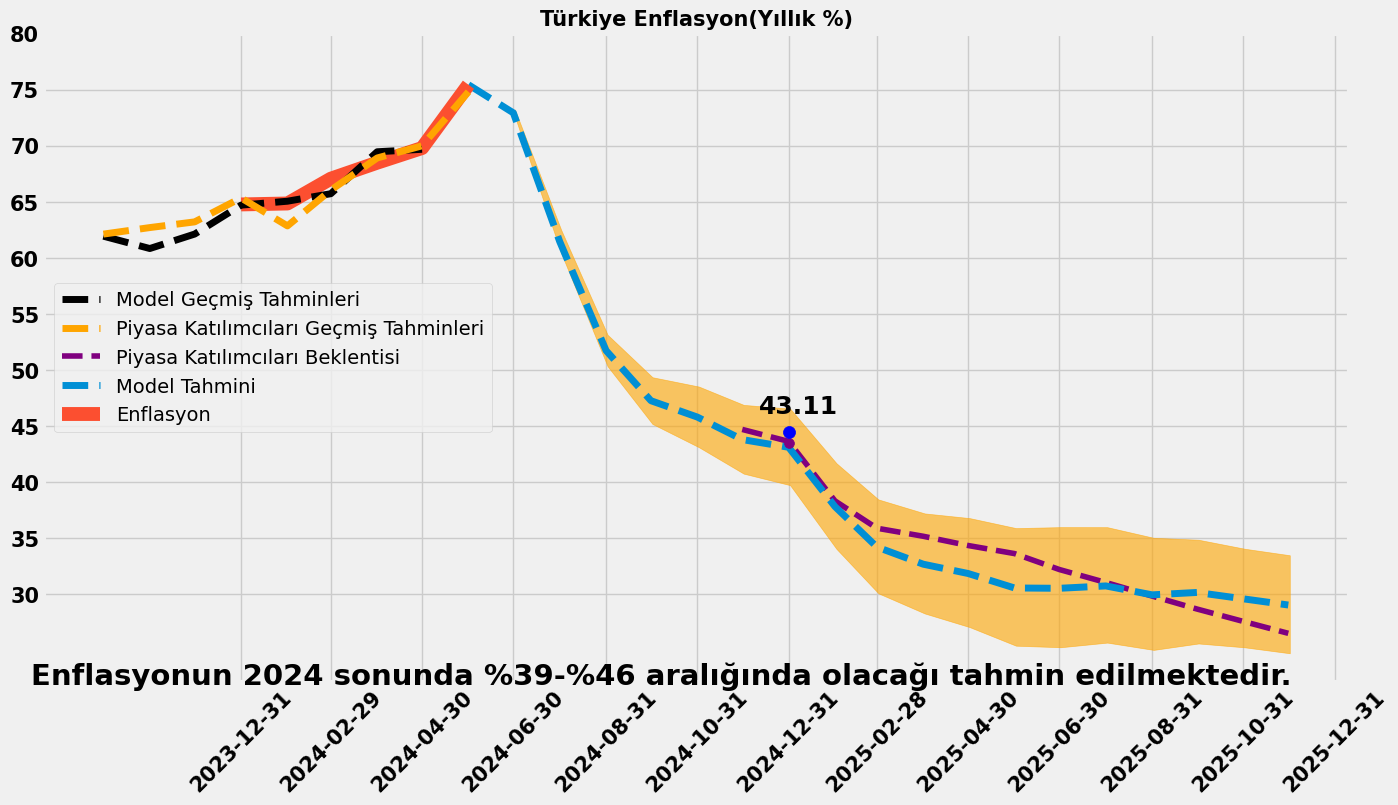

In [470]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50)
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",end="2024-04-30",freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.plot(caritüfe["Enflasyon Tahmin"],'--',label="Piyasa Katılımcıları Geçmiş Tahminleri",color="orange",linewidth=5,zorder=3)
plt.plot((piyasaenf.pct_change(12)*100).iloc[-14:-1],"--",color="purple",label="Piyasa Katılımcıları Beklentisi")
plt.scatter(x=yıllıktahmin.index[25],y=yıllıktahmin.iloc[25,0],color='blue',zorder=4,s=75)
plt.plot(yıllıktahmin["Ensemble"].iloc[18:-1],'--',label="Model Tahmini",linewidth=5)
plt.plot(yıllıktahmin["Ensemble"].iloc[13:19],label="Enflasyon",linewidth=10)
plt.fill_between(yıllıktahmin.iloc[19:].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[19:].shift(1), yıllıktahmin["Minimum"].iloc[19:].shift(1), alpha=0.6, color='orange')
annotation_date = mdates.datestr2num('2025-12')
plt.text(mdates.datestr2num('2025-02'), float(sonu12024)+3, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[13::2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05')])

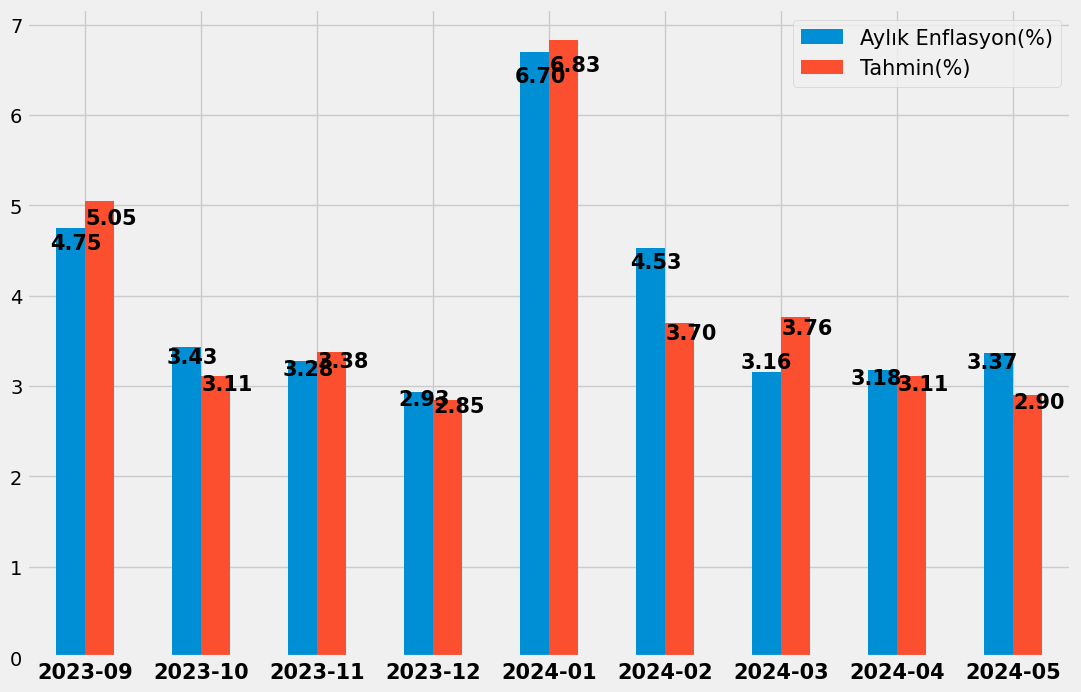

In [414]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=9,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(12,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)


plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [415]:
usd

,USD/TL
2006-01-02,1.3483
2006-01-03,1.3506
2006-01-04,1.3484
2006-01-05,1.3381
2006-01-06,1.3362
...,...
2024-06-26,32.9608
2024-06-27,32.9633
2024-06-28,32.9009
2024-07-01,32.8853


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (14,) and arg 1 with shape (19,).

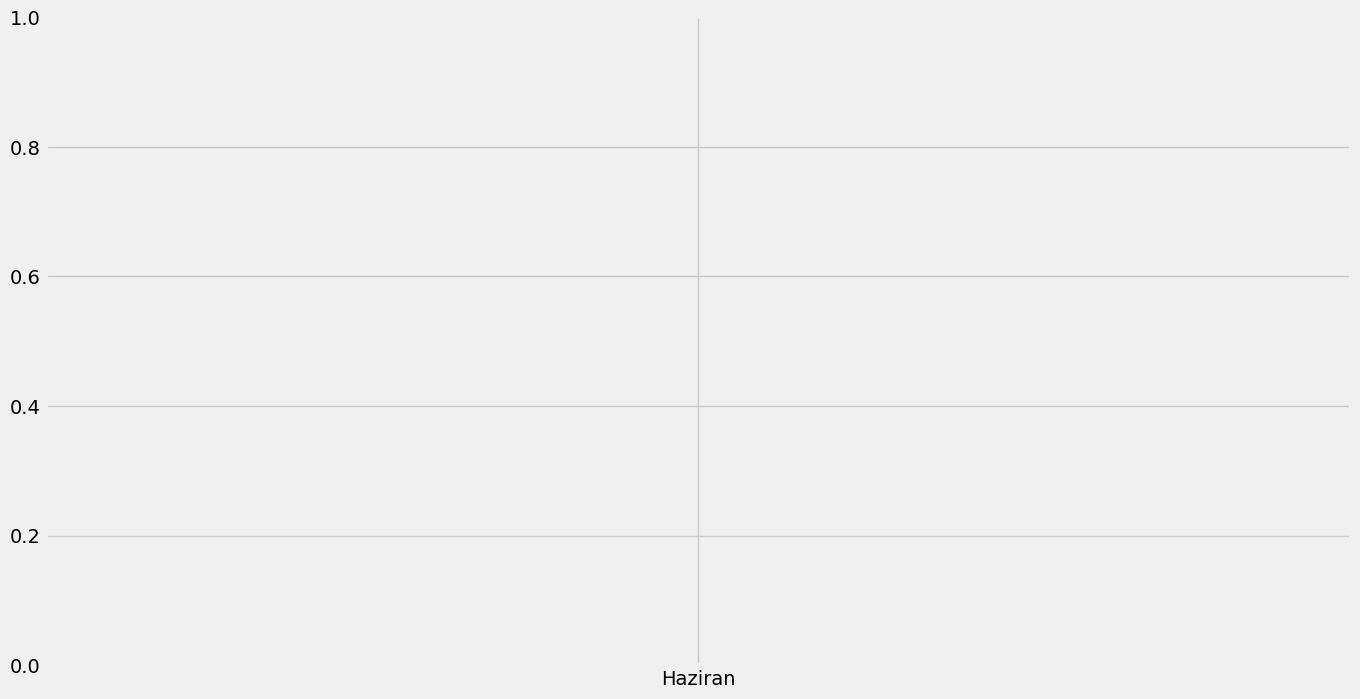

In [416]:
plt.figure(figsize=(15,8))
plt.bar(x=["Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık","Ocak 25","Şubat 25","Mart 25","Nisan 25","Mayıs 25","Haziran 25","Temmuz 25"],height=aylıktahmin.iloc[:,-3])
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0,-3])[:4],xy=(-0.25,aylıktahmin.iloc[0,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1,-3])[:4],xy=(0.75,aylıktahmin.iloc[1,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2,-3])[:4],xy=(1.75,aylıktahmin.iloc[2,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3,-3])[:4],xy=(2.75,aylıktahmin.iloc[3,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4,-3])[:4],xy=(3.75,aylıktahmin.iloc[4,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5,-3])[:4],xy=(4.75,aylıktahmin.iloc[5,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6,-3])[:4],xy=(5.75,aylıktahmin.iloc[6,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7,-3])[:4],xy=(6.75,aylıktahmin.iloc[7,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8,-3])[:4],xy=(7.75,aylıktahmin.iloc[8,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9,-3])[:4],xy=(8.75,aylıktahmin.iloc[9,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10,-3])[:4],xy=(9.75,aylıktahmin.iloc[10,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11,-3])[:4],xy=(10.75,aylıktahmin.iloc[11,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[12,-3])[:4],xy=(11.75,aylıktahmin.iloc[12,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[13,-3])[:4],xy=(12.75,aylıktahmin.iloc[13,-3]*0.95),fontweight="bold",fontsize=15)


